In [28]:
import numpy as np
import math
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

In [29]:
def deserialize_matrix(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        matrix = []
        for l in lines:
            l = l.strip()
            l = l.replace(' ', '')
            tokens = l.split(',')
            row = [float(el) for el in tokens if el != "" and el != " "]
            matrix.append(row)
    return np.asarray(matrix)

In [30]:
def deserialize_id_map(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        idmap = dict()
        for l in lines:
            tokens = l.split(",")
            col_id = int(tokens[0])
            col_name = tokens[1].strip()
            idmap[col_id] = col_name
    return idmap

In [31]:
def transform_matrix_dataframe(matrix):
    idx = [i for i in range(matrix.shape[0])]
    matrix_df = pd.DataFrame(data=matrix, index=idx, columns=idx)
    return matrix_df

In [74]:
def name_pair(pair, idmap):
    i, j = pair
    return idmap[i] + " ~ " + idmap[j]

In [32]:
input_matrix = "temp/mit_matrix_n2_k64.dat"
input_idmap = "temp/mit_matrix_n2_k64.dat_nameMap"

In [33]:
matrix = deserialize_matrix(input_matrix)

In [34]:
idmap = deserialize_id_map(input_idmap)

In [35]:
matrix.shape

(1599, 1599)

In [36]:
len(idmap)

1599

In [37]:
list(idmap.items())[0:5]

[(0, 'Fclt_building_hist_1.csv->Date Occupied'),
 (1, 'All_olap_descriptor_types.csv->Descriptor Type'),
 (2, 'Sdo_units_of_measure.csv->Unit Of Meas Type'),
 (3, 'Sdo_crs_engineering.csv->Data Source'),
 (4, 'short_fclt_rooms_hist.csv->Fclt Floor Key')]

In [38]:
aggregated_jc = [np.sum(row) for row in matrix]

In [39]:
max(aggregated_jc)

448.19444333

In [40]:
min(aggregated_jc)

0.0

In [41]:
num_zeros = [len(matrix) - np.count_nonzero(row) for row in matrix]

In [42]:
max(num_zeros)

1599

In [43]:
min(num_zeros)

1133

In [44]:
avg_jc_per_column_norm_nonzeros = [aggr/(len(matrix) - zeros) for aggr, zeros in zip(aggregated_jc, num_zeros)]

/Users/ra-mit/development/virtualenvs/fuzzylazo/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [45]:
max(avg_jc_per_column_norm_nonzeros)

1.0

In [46]:
min(avg_jc_per_column_norm_nonzeros)

0.06719495726666666

In [47]:
avg_jc_per_column = [aggr/len(matrix) for aggr in aggregated_jc if aggr > 0]  # not counting 0 aggr values!!

In [48]:
max(avg_jc_per_column)

0.2802967125265791

In [49]:
min(avg_jc_per_column)

0.0006173730456535334

### Proposal of computing beta and theta matrix

In [50]:
theta_matrix = []
for row in matrix:
    aggr_jc = sum(row)
    total_d = len(row)
    if aggr_jc > 0:
        beta = math.log((total_d/aggr_jc))
        theta_row = []
        for jc in row:
            theta = (jc * beta) / math.log(total_d)
            theta_row.append(theta)
    else:
        theta_row = [0 for jc in row]
    theta_matrix.append(theta_row)

In [51]:
theta_matrix = np.asarray(theta_matrix)

In [52]:
matrix_df = transform_matrix_dataframe(matrix)
theta_matrix_df = transform_matrix_dataframe(theta_matrix)

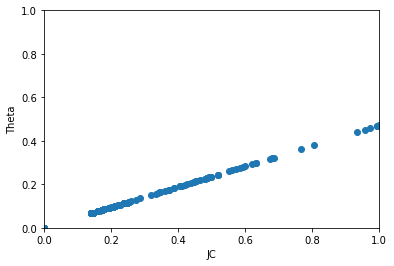

In [53]:
fig, ax = plt.subplots()
plt.ylim((0, 1))
plt.xlim((0, 1))
ax.set_xlabel("JC")
ax.set_ylabel("Theta")
ax.plot(matrix[1], theta_matrix[1], 'o')

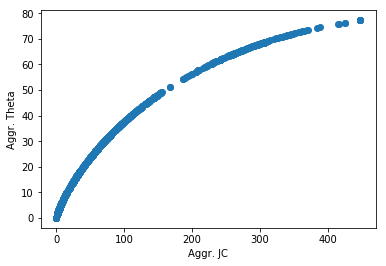

In [54]:
fig, ax = plt.subplots()
#plt.ylim((0, 1))
#plt.xlim((0, 1))
ax.set_xlabel("Aggr. JC")
ax.set_ylabel("Aggr. Theta")
ax.plot([sum(x) for x in matrix], [sum(x) for x in theta_matrix], 'o')

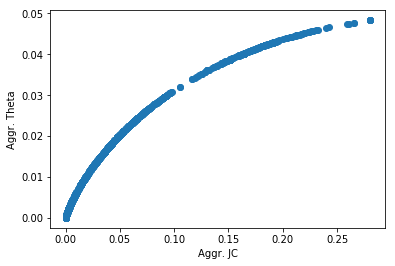

In [55]:
fig, ax = plt.subplots()
#plt.ylim((0, 1))
#plt.xlim((0, 1))
ax.set_xlabel("Aggr. JC")
ax.set_ylabel("Aggr. Theta")
ax.plot([sum(x)/len(x) for x in matrix], [sum(x)/len(x) for x in theta_matrix], 'o')

### check in which cases theta is larger than JC, or does it always damp it?

In [56]:
import itertools
total_larger = 0
for i, j in itertools.product([x for x in range(matrix.shape[0])], [x for x in range(matrix.shape[0])]):
    if theta_matrix[i][j] > matrix[i][j]:
        total_larger += 1
        print("Theta: " + str(theta_matrix[i][j]))
        print("JC: " + str(matrix[i][j]))
print(total_larger)

Theta: 0.991915148124266
JC: 0.99065423
Theta: 0.9926692844725535
JC: 0.9915254
Theta: 0.9889061819891763
JC: 0.9871795
Theta: 0.9889604055336504
JC: 0.9872421
Theta: 0.9895498742947397
JC: 0.98792267
Theta: 0.9927915923396584
JC: 0.9916667
6


### plotting the diff between both

In [57]:
diffs = []
for i, j in itertools.product([x for x in range(matrix.shape[0])], [x for x in range(matrix.shape[0])]):
    # ONLY COUNT NON-ZERO
    if matrix[i][j] > 0:
        diff = matrix[i][j] - theta_matrix[i][j]
        diffs.append(diff)
diffs = np.asarray(diffs)
max_diff = np.max(diffs)
min_diff = np.min(diffs)
med_diff = np.percentile(diffs, 50)
p95_diff = np.percentile(diffs, 95)
p90_diff = np.percentile(diffs, 90)
p5_diff = np.percentile(diffs, 5)
p75_diff = np.percentile(diffs, 75)
p85_diff = np.percentile(diffs, 85)
avg_diff = np.average(diffs)
print("M: " + str(max_diff))
print("m: " + str(min_diff))
print("avg: " + str(avg_diff))
print("med: " + str(med_diff))
print("p95: " + str(p95_diff))
print("p90: " + str(p90_diff))
print("p5: " + str(p5_diff))
print("p75: " + str(p75_diff))
print("p85: " + str(p85_diff))

M: 0.8275879767398286
m: -0.0017266819891763596
avg: 0.3231151660891969
med: 0.26179260480984234
p95: 0.7507212539236987
p90: 0.6753463256387479
p5: 0.0757316684008584
p75: 0.4858193135266591
p85: 0.6122401335965182


#### For a given threshold, which columns make it using JC that do not make it using Theta

In [91]:
def candidates(matrix, threshold):
    pairs = []
    for i, row in enumerate(matrix):
        for j, el in enumerate(row):
            if el > threshold and i != j:
                pairs.append((i, j))
    return pairs

In [100]:
for th in [0.5, 0.6, 0.7, 0.8, 0.9]:
    jc_pairs = candidates(matrix, th)
    th_pairs = candidates(theta_matrix, th)
    print("Threshold: " + str(th))
    print("JC: " + str(len(jc_pairs)))
    print("TH: " + str(len(th_pairs)))

Threshold: 0.5
JC: 111394
TH: 2072
Threshold: 0.6
JC: 88787
TH: 1021
Threshold: 0.7
JC: 67744
TH: 453
Threshold: 0.8
JC: 50823
TH: 170
Threshold: 0.9
JC: 33489
TH: 14


In [96]:
jc_pairs = candidates(matrix, 0.7)
th_pairs = candidates(theta_matrix, 0.7)
print("JC pairs total: " + str(len(jc_pairs)))
print("TH pairs total: " + str(len(th_pairs)))

JC pairs total: 67744
TH pairs total: 453


In [77]:
# bad
name_pair(jc_pairs[0], idmap)

'All_olap_descriptor_types.csv->Descriptor Type ~ Sdo_crs_engineering.csv->Coord Ref Sys Name'

In [79]:
# bad
name_pair(jc_pairs[1], idmap)

'All_olap_descriptor_types.csv->Descriptor Type ~ Sdo_coord_op_methods.csv->Coord Op Method Name'

In [82]:
name_pair(jc_pairs[2], idmap)

'All_olap_descriptor_types.csv->Descriptor Type ~ short_library_reserve_catalog.csv->Catalog Publisher'

In [78]:
name_pair(th_pairs[0], idmap)

'Fclt_building_list.csv->Building Type ~ Fac_building.csv->Building Type'

In [80]:
name_pair(th_pairs[1], idmap)

'Fclt_building_list.csv->Building Type ~ Fclt_building_hist_1.csv->Building Type'

In [83]:
name_pair(th_pairs[2], idmap)

'Fclt_building_list.csv->Building Type ~ Fclt_building.csv->Building Type'

In [84]:
name_pair(th_pairs[3], idmap)

'Fclt_building_hist_1.csv->Access Level Code ~ Fclt_building.csv->Access Level Code'

In [89]:
c = 0
for i, j in th_pairs:
    iname = idmap[i].split("->")[1]
    jname = idmap[j].split("->")[1]
    if iname != jname:
        c += 1
        #print(name_pair((i,j), idmap))
print(c)

195


## Comparing JC across ngram sizes

In [19]:
im2 = "temp/mit_matrix_n2_k64.dat"
im3 = "temp/mit_matrix_n3_k64.dat"

In [53]:
m2 = deserialize_matrix(im2)
m3 = deserialize_matrix(im3)

#### Hypothesis 1: Non-zero JC values in m3 must always be smaller than non-zero JC values in m2

In [54]:
m2.shape

(1599, 1599)

In [55]:
m3.shape

(1599, 1599)

In [90]:
# we need to keep in mind the 0.05 normal error from the lazo method, so we can relax that
fail = 0
for r2, r3 in zip(m2, m3):
    for el2, el3 in zip(r2, r3):
        if el2 > 0 and el3 > 0:
            if (el3 - 0.05) > el2:  # D value of lazo method
#                 print(str(el3) + "-" + str(el2))
                fail += 1

In [93]:
total_els = 1599*1599
perc_fail = (float(fail) / float(total_els))

In [94]:
perc_fail

0.0015887040094242767

#### 1.5 per thousand fail --> need to understand why

In [95]:
im3 = "temp/mit_matrix_n3_k64.dat"
im4 = "temp/mit_matrix_n4_k64.dat"

In [96]:
m3 = deserialize_matrix(im3)
m4 = deserialize_matrix(im4)

In [97]:
m3.shape

(1599, 1599)

In [98]:
m4.shape

(1599, 1599)

In [99]:
fail = 0
for r3, r4 in zip(m3, m4):
    for el3, el4 in zip(r3, r4):
        if el3 > 0 and el4 > 0:
            if (el4 - 0.05) > el3:  # D value of lazo method
#                 print(str(el4) + "-" + str(el3))
                fail += 1

In [100]:
total_els = 1599*1599
perc_fail = (float(fail) / float(total_els))

In [101]:
perc_fail

0.0006867957263783924

#### 0.6 per thousand fail, trend goes in the direction of supporting the hypothesis

In [103]:
im4 = "temp/mit_matrix_n4_k64.dat"
im5 = "temp/mit_matrix_n5_k64.dat"

In [104]:
m4 = deserialize_matrix(im4)
m5 = deserialize_matrix(im5)

In [105]:
m4.shape

(1599, 1599)

In [106]:
m5.shape

(1599, 1599)

In [107]:
fail = 0
for r4, r5 in zip(m4, m5):
    for el4, el5 in zip(r4, r5):
        if el4 > 0 and el5 > 0:
            if (el5 - 0.05) > el4:  # D value of lazo method
#                 print(str(el5) + "-" + str(el4))
                fail += 1

In [108]:
total_els = 1599*1599
perc_fail = (float(fail) / float(total_els))

In [109]:
perc_fail

0.0002718240488798307

#### 0.2 per thousand fail, trend goes in the direction of supporting the hypothesis

In [110]:
im5 = "temp/mit_matrix_n5_k64.dat"
im6 = "temp/mit_matrix_n6_k64.dat"

In [111]:
m5 = deserialize_matrix(im5)
m6 = deserialize_matrix(im6)

In [112]:
m5.shape

(1599, 1599)

In [113]:
m6.shape

(1599, 1599)

In [114]:
fail = 0
for r5, r6 in zip(m5, m6):
    for el5, el6 in zip(r5, r6):
        if el5 > 0 and el6 > 0:
            if (el6 - 0.05) > el5:  # D value of lazo method
#                 print(str(el6) + "-" + str(el5))
                fail += 1

In [115]:
total_els = 1599*1599
perc_fail = (float(fail) / float(total_els))

In [116]:
perc_fail

0.0006957913423844875

#### 0.6 per thousand fail, trend goes in the direction of supporting the hypothesis

## TESTING

In [152]:
non_zero_row = [el for el in m2[0] if el > 0]

In [153]:
len(non_zero_row)

18

In [154]:
non_zero_row

[0.9895834,
 0.16666667,
 0.48958334,
 0.5260416,
 0.21875,
 0.4635417,
 0.47916666,
 0.203125,
 0.46875,
 0.40625,
 0.3541667,
 0.5260416,
 0.16666667,
 0.17708333,
 0.16666667,
 0.5364584,
 0.40104166,
 0.15104166]

In [159]:
aggr = np.sum(non_zero_row)

In [160]:
aggr

6.89062506

In [161]:
norm = [el/aggr for el in non_zero_row]

In [163]:
maxnorm = max(norm)
minnorm = min(norm)
beta_scores = [(el - minnorm) / (maxnorm - minnorm) for el in norm]

In [164]:
beta_scores

[1.0,
 0.01863355066856898,
 0.4037266886678772,
 0.44720485828171175,
 0.08074534250376136,
 0.372670822563943,
 0.391304313605188,
 0.06211180376065718,
 0.37888196239342836,
 0.30434780742101164,
 0.24223605136221368,
 0.44720485828171175,
 0.01863355066856898,
 0.03105590188032862,
 0.01863355066856898,
 0.4596273764499785,
 0.29813661988966705,
 0.0]

In [165]:
final_scores = [jc * beta for jc, beta in zip(non_zero_row, beta_scores)]

In [172]:
for el in zip(final_scores, non_zero_row):
    print(el)

(0.9895834, 0.9895834)
(0.0031055918402066655, 0.16666667)
(0.19765786068515945, 0.48958334)
(0.2352483591782849, 0.5260416)
(0.017663043672697797, 0.21875)
(0.1727484666316885, 0.4635417)
(0.1874999809937905, 0.47916666)
(0.012616460138883491, 0.203125)
(0.17760091987191953, 0.46875)
(0.12364129676478598, 0.40625)
(0.08579194293198572, 0.3541667)
(0.2352483591782849, 0.5260416)
(0.0031055918402066655, 0.16666667)
(0.005499482521121854, 0.17708333)
(0.0031055918402066655, 0.16666667)
(0.24657096696655315, 0.5364584)
(0.1195652049473411, 0.40104166)
(0.0, 0.15104166)
